In [1]:
from dn_utils.path import path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import json
from dn_utils.misc import tidy_data
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from dn_utils.style import ORANGE, BLUE
from statsmodels.stats.multitest import fdrcorrection

In [2]:
atlas = "combined_roi"
gamma_range = np.arange(0.5, 2.5, 0.5)

In [7]:
path_corrmats = join(path["bsc"], "corrmats")
path_corrmats_unthr = join(path_corrmats, atlas, "unthr")

df_dissim = {}
z, ppos, pneg = {}, {}, {}
for gamma in gamma_range:
    
    gamma_str = str(float(gamma)).replace(".", "_")
    path_corrmats_unthr_gamma = join(path_corrmats_unthr, f"gamma_{gamma_str}")

    # Load data
    z[gamma] = np.load(join(path_corrmats_unthr_gamma, "z_aggregated.npy"))
    ppos[gamma] = np.load(join(path_corrmats_unthr_gamma, "ppos_aggregated.npy"))
    pneg[gamma] = np.load(join(path_corrmats_unthr_gamma, "pneg_aggregated.npy"))
    df_dissim[gamma] = pd.read_csv(join(path_corrmats_unthr_gamma, 
                                        "node_profile_dissimilarity.csv"))
    
df_dissim = pd.concat(df_dissim.values(), axis=1, join="inner")
df_dissim = df_dissim.loc[:,~df_dissim.columns.duplicated()]
df_dissim = df_dissim.loc[:,~df_dissim.columns.str.startswith('Unnamed')]
    
# Load subject exclusion
df_exclusion = pd.read_csv(join(path["nistats"], "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]

# Load ROI table
df_roi = pd.read_csv(join(path_corrmats, atlas, "roi_table_filtered.csv"))

# Meta information about corrmats dimensions
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read()) 
    
n_subjects_ok = sum(ok_index)
n_conditions = len(corrmats_meta["dim2"])
n_perr_sign = len(corrmats_meta["dim3"])
n_roi = len(corrmats_meta["dim4"])

labels = [pd.Series(corrmats_meta["dim1"])[ok_index].to_list(),
          corrmats_meta["dim2"],
          corrmats_meta["dim3"]]
palette = {"perr_pos": ORANGE, "perr_neg": BLUE}

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.0505 1.0000 28.0000 0.8239
perr_sign      2.1765 1.0000 28.0000 0.1513
con:perr_sign  0.7947 1.0000 28.0000 0.3803



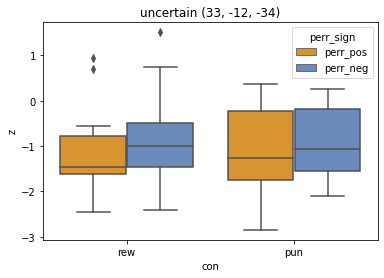

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.1461 1.0000 28.0000 0.7052
perr_sign      1.6513 1.0000 28.0000 0.2093
con:perr_sign  1.8892 1.0000 28.0000 0.1802



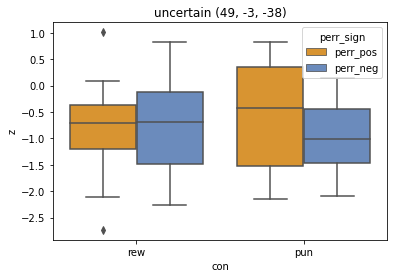

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.2173 1.0000 28.0000 0.6447
perr_sign      0.0014 1.0000 28.0000 0.9709
con:perr_sign  2.6965 1.0000 28.0000 0.1118



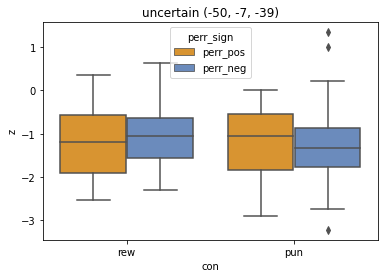

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            9.1599 1.0000 28.0000 0.0053
perr_sign      0.3710 1.0000 28.0000 0.5474
con:perr_sign  0.8060 1.0000 28.0000 0.3770



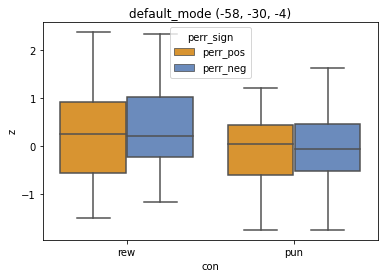

corrected pvals_con: [0.82385476 0.82385476 0.82385476 0.02103961]
corrected pvals_perr: [0.41862912 0.41862912 0.97091819 0.72982907]
corrected pvals_interaction: [0.38028169 0.36039805 0.36039805 0.38028169]


In [5]:
gamma = 0.5

gamma_str = str(float(gamma)).replace(".", "_")

rois = df_dissim.loc[df_dissim[f"pval_fdr_{gamma_str}"] < 0.05, :]
rois_names = (
    rois["netName"] + 
    " (" + rois["x"].astype("str") + 
    ", " + rois["y"].astype("str") + 
    ", " + rois["z"].astype("str") + ")"
)
rois_idx = rois.index

pvals_con, pvals_perr, pvals_interaction = [], [], []

for roi_idx, roi_name in zip(rois_idx, rois_names):

    depvar = "z"
    data = tidy_data(
        z[gamma][ok_index, :, :, roi_idx],
        depvar=depvar,
        columns=["sub", "con", "perr_sign"],
        labels=labels,
    )
    anova = AnovaRM(
        data=data, 
        depvar=depvar, 
        subject="sub", 
        within=["con", "perr_sign"]
    )
    results = anova.fit()
    print(results)
    
    pvals_con.append(results.anova_table["Pr > F"]["con"])
    pvals_perr.append(results.anova_table["Pr > F"]["perr_sign"])
    pvals_interaction.append(results.anova_table["Pr > F"]["con:perr_sign"])

    sns.boxplot(
        x="con", 
        y=depvar, 
        hue="perr_sign", 
        data=data, 
        palette=palette,
    )
    plt.title(roi_name)
    plt.show()
    
print(f"corrected pvals_con: {fdrcorrection(pvals_con)[1]}")
print(f"corrected pvals_perr: {fdrcorrection(pvals_perr)[1]}")
print(f"corrected pvals_interaction: {fdrcorrection(pvals_interaction)[1]}")